<a id='top'></a><a name='top'></a>
# Chapter 8: The Attention Mechanism from Scratch

* [Introduction](#introduction)
* [8.0 Imports and Setup](#8.0)
* [8.1 The Attention Mechanism](#8.1)
* [8.2 The General Attention Mechanism](#8.2)
* [8.3 The General Attention Mechanism with NumPy and SciPy](#8.3)
    - [8.3.1 Encoder representations of four different words](#8.3.1)
    - [8.3.2 Stacking the word embeddings into a single array](#8.3.2)
    - [8.3.3 Generate the weight matrices](#8.3.3)
    - [8.3.4 Generate the queries, keys and values with matrix multiplication](#8.3.4)
    - [8.3.5 Score the query vectors against all key vectors](#8.3.5)
    - [8.3.6 Compute the weights by a softmax operation](#8.3.6)
    - [8.3.7 Compute the attention by a weighted sum of the value vectors](#8.3.7)
* [Extra](#extra)

---
<a name='introduction'></a><a id='introduction'></a>
# Introduction
<a href="#top">[back to top]</a>

### Dataset

* Toy dataset


### Explore

* How the attention mechanism uses a weighted sum of all the encoder hidden states to flexibly focus the attention of the decoder on the most relevant parts of the input sequence.
* How the attention mechanism can be generalized for tasks where the information may not necessarily be related in a sequential fashion.
* How to implement the general attention mechanism in Python with NumPy and Scipy.

---
<a name='8.0'></a><a id='8.0'></a>
# 8.0 Imports and Setup
<a href="#top">[back to top]</a>

In [1]:
req_file = "requirements_08.txt"

In [2]:
%%writefile {req_file}
isort
scikit-learn-intelex
watermark

Overwriting requirements_08.txt


In [3]:
import sys
IS_COLAB = 'google.colab' in sys.modules

if IS_COLAB:
    print("Installing packages")
    !pip install --upgrade --quiet -r {req_file}
else:
    print("Running locally.")

# Need to import before sklearn
from sklearnex import patch_sklearn
patch_sklearn()

Running locally.


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [3]:
%%writefile imports.py
import locale
import math
import pprint
import warnings

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.special import softmax
from tqdm.auto import tqdm
from watermark import watermark

Overwriting imports.py


In [4]:
!isort imports.py --sl
!cat imports.py

import locale
import math
import pprint
import warnings

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.special import softmax
from tqdm.auto import tqdm
from watermark import watermark


In [6]:
import locale
import math
import pprint
import warnings

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.special import softmax
from tqdm.auto import tqdm
from watermark import watermark

In [6]:
def HR():
    print("-"*40)
    
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"

locale.getpreferredencoding = getpreferredencoding
warnings.filterwarnings('default')
BASE_DIR = '.'
sns.set_style("darkgrid")
tqdm.pandas(desc="progress-bar")
pp = pprint.PrettyPrinter(indent=4)

seed = 42

print(watermark(iversions=True,globals_=globals(),python=True,machine=True))

Python implementation: CPython
Python version       : 3.8.12
IPython version      : 7.34.0

Compiler    : Clang 13.0.0 (clang-1300.0.29.3)
OS          : Darwin
Release     : 21.6.0
Machine     : x86_64
Processor   : i386
CPU cores   : 4
Architecture: 64bit

numpy     : 1.23.5
seaborn   : 0.12.1
matplotlib: 3.6.2



---
<a name='8.1'></a><a id='8.1'></a>
# 8.1 The Attention Mechanism
<a href="#top">[back to top]</a>

* Dzmitry Bahdanau, Kyunghyun Cho, and Yoshua Bengio. “Neural Machine Translation by Jointly Learning to Align and Translate”. In: Proc. 3rd International Conference on Learning Representations (ICLR 2015). May 2015.
http://arxiv.org/abs/1409.0473

---
<a name='8.2'></a><a id='8.2'></a>
# 8.2 The General Attention Mechanism
<a href="#top">[back to top]</a>

---
<a name='8.3'></a><a id='8.3'></a>
# 8.3 The General Attention Mechanism with NumPy and SciPy
<a href="#top">[back to top]</a>

---
<a name='8.3.1'></a><a id='8.3.1'></a>
## 8.3.1 Encoder representations of four different words
<a href="#top">[back to top]</a>

* Calculate a small matrix representing four words. 
* Define the word embeddings manually.

In [7]:
word_1 = np.array([1, 0, 0])
word_2 = np.array([0, 1, 0])
word_3 = np.array([1, 1, 0])
word_4 = np.array([0, 0, 1])

print(word_1)
print(word_2)
print(word_3)
print(word_4)

[1 0 0]
[0 1 0]
[1 1 0]
[0 0 1]


---
<a name='8.3.2'></a><a id='8.3.2'></a>
## 8.3.2 Stacking the word embeddings into a single array
<a href="#top">[back to top]</a>

* Stack the word embeddings for more convenience.

In [8]:
words = np.array([word_1, word_2, word_3, word_4])

print(words.shape)
HR()

print(words)

(4, 3)
----------------------------------------
[[1 0 0]
 [0 1 0]
 [1 1 0]
 [0 0 1]]


---
<a name='8.3.3'></a><a id='8.3.3'></a>
## 8.3.3 Generate the weight matrices
<a href="#top">[back to top]</a>

* We multiply the word matrices by the word embeddings to generate the queries, keys and values.
* Here we generate the weight matrices randomly. In actual practice, these would be learned during training.
* **The number of rows of each of these matrices is equal to the dimensionality of the word embeddings (which in this case is three) to allow us to perform the matrix multiplication.** 
* Subsequently, the query, key, and value vectors for each word are generated by multiplying each word embedding by each of the weight matrices.

In [9]:
np.random.seed(seed)

W_Q = np.random.randint(low=3, size=(3, 3))
W_K = np.random.randint(low=3, size=(3, 3))
W_V = np.random.randint(low=3, size=(3, 3))

print("W_Q, W_K, W_V")
HR()
print(W_Q)
HR()
print(W_K)
HR()
print(W_V)

W_Q, W_K, W_V
----------------------------------------
[[2 0 2]
 [2 0 0]
 [2 1 2]]
----------------------------------------
[[2 2 2]
 [0 2 1]
 [0 1 1]]
----------------------------------------
[[1 1 0]
 [0 1 1]
 [0 0 0]]


---
<a name='8.3.4'></a><a id='8.3.4'></a>
## 8.3.4 Generate the query, key and value matrices

<a href="#top">[back to top]</a>

Here, we multiply each word embedding by each of the weight matrices.

In [10]:
print(words.shape)
print(W_Q.shape)

(4, 3)
(3, 3)


In [11]:
Q = words @ W_Q
K = words @ W_K
V = words @ W_V

print("Q, K, V")
HR()

print(Q)
HR()

print(K)
HR()

print(V)

Q, K, V
----------------------------------------
[[2 0 2]
 [2 0 0]
 [4 0 2]
 [2 1 2]]
----------------------------------------
[[2 2 2]
 [0 2 1]
 [2 4 3]
 [0 1 1]]
----------------------------------------
[[1 1 0]
 [0 1 1]
 [1 2 1]
 [0 0 0]]


---
<a name='8.3.5'></a><a id='8.3.5'></a>
## 8.3.5 Score the query vectors against all key vectors
<a href="#top">[back to top]</a>

We use a dot-product operation here for the scaled attention scores.

In [12]:
print(f"Query matrix:\n{Q}")

Query matrix:
[[2 0 2]
 [2 0 0]
 [4 0 2]
 [2 1 2]]


In [13]:
print(f"Key matrix in transposed format:\n{K.T}")

Key matrix in transposed format:
[[2 0 2 0]
 [2 2 4 1]
 [2 1 3 1]]


In [14]:
scores = Q @ K.transpose()

print(scores)

[[ 8  2 10  2]
 [ 4  0  4  0]
 [12  2 14  2]
 [10  4 14  3]]


---
<a name='8.3.6'></a><a id='8.3.6'></a>
## 8.3.6 Compute the attention weights by a softmax operation
<a href="#top">[back to top]</a>

* Scaled softmax attention_scores for each vector.
* The score values are subsequently passed through a softmax operation to generate the weights. 
* It is common practice to divide the score values by the square root of the dimensionality of the key vectors (in this case, three) to keep the gradients stable.


In [15]:
# Square root of the dimensionality of the key vectors
print(K.shape[1])

sqrt_k = math.sqrt(K.shape[1])

print(sqrt_k)

3
1.7320508075688772


In [16]:
attention_weights = softmax((scores / sqrt_k), axis=1)

print(attention_weights.round(3))

[[0.236 0.007 0.749 0.007]
 [0.455 0.045 0.455 0.045]
 [0.239 0.001 0.759 0.001]
 [0.09  0.003 0.906 0.002]]


---
<a name='8.3.7'></a><a id='8.3.7'></a>
## 8.3.7 Compute the attention output by a weighted sum of the value vectors
<a href="#top">[back to top]</a>

In [17]:
attention_weights.round(3)

array([[0.236, 0.007, 0.749, 0.007],
       [0.455, 0.045, 0.455, 0.045],
       [0.239, 0.001, 0.759, 0.001],
       [0.09 , 0.003, 0.906, 0.002]])

In [18]:
V

array([[1, 1, 0],
       [0, 1, 1],
       [1, 2, 1],
       [0, 0, 0]])

In [19]:
attention_output = attention_weights @ V

print(attention_output.shape)
HR()

print(attention_output)

(4, 3)
----------------------------------------
[[0.98522025 1.74174051 0.75652026]
 [0.90965265 1.40965265 0.5       ]
 [0.99851226 1.75849334 0.75998108]
 [0.99560386 1.90407309 0.90846923]]


---
**Visualizations**

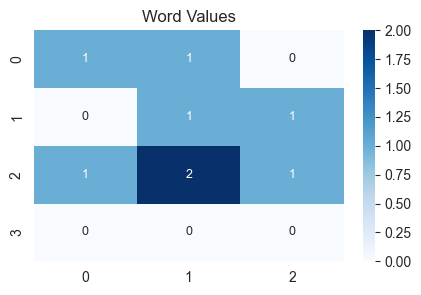

In [44]:
annotation_size = 9
plot_size = (5,3)

plt.figure(figsize=plot_size)
plt.title("Word Values")
sns.heatmap(V, annot=True, cmap='Blues', annot_kws={"size": annotation_size})

plt.show()

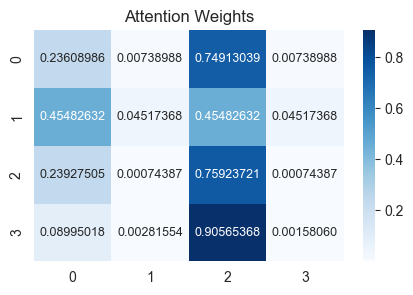

In [39]:
plt.figure(figsize=plot_size)
plt.title("Attention Weights")
sns.heatmap(attention_weights, annot=True, cmap='Blues', fmt='.8f', annot_kws={"size": annotation_size})
plt.show()

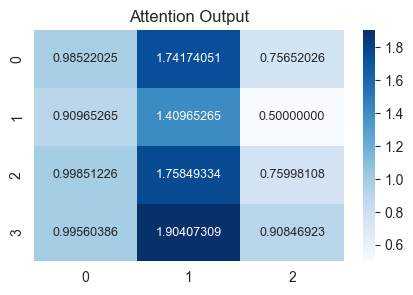

In [46]:
plt.figure(figsize=plot_size)
plt.title("Attention Output")
sns.heatmap(attention_output, annot=True, cmap='Blues', fmt='.8f', annot_kws={"size": annotation_size})
plt.show()

---
---
---

---
<a name='extra'></a><a id='extra'></a>
## Extra
<a href="#top">[back to top]</a>

* Assume we have num_inputs results with learned weights (they were not trained in this example).
* Assume we are implementing the original Transformer paper. 
* We will have num_inputs results of 64 dimensions each.
* Assume we have trained the 8 heads of the attention sub-layer.
* From https://github.com/PacktPublishing/Transformers-for-Natural-Language-Processing/blob/main/Chapter01/Multi_Head_Attention_Sub_Layer.ipynb

In [23]:
np.random.seed(seed)

num_inputs = 4
full_dim = 512
num_heads = 8
output_dim = (full_dim // num_heads) # ensure result is an integer

print(num_inputs)
print(full_dim)
print(num_heads)
print(output_dim)

attn_heads = [np.random.random((num_inputs, output_dim)) for x in range(0, num_heads)]

4
512
8
64


In [24]:
print("Concatenation of heads 1 to 8 to obtain the original 8x64=512 output dimension of the model")
HR()

# Equivalent to concatenation along the second axis
output_attention = np.hstack(attn_heads)

# Equivalent to this:
# output_attention = np.concatenate(attn_heads, axis=1)

print(output_attention.shape)
HR()

print(output_attention.round(num_inputs))

Concatenation of heads 1 to 8 to obtain the original 8x64=512 output dimension of the model
----------------------------------------
(4, 512)
----------------------------------------
[[0.3745 0.9507 0.732  ... 0.8465 0.9189 0.2522]
 [0.2809 0.5427 0.1409 ... 0.593  0.3915 0.4126]
 [0.007  0.5107 0.4174 ... 0.8026 0.4582 0.483 ]
 [0.9004 0.6331 0.339  ... 0.7228 0.0677 0.7078]]


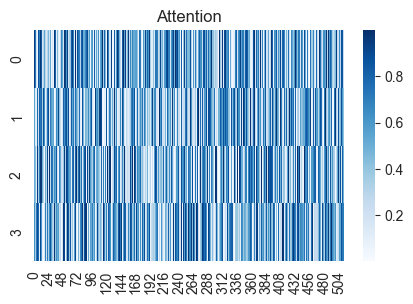

In [25]:
plt.figure(figsize=plot_size)
plt.title("Attention")
sns.heatmap(output_attention, annot=False, cmap='Blues')
plt.show()

In [26]:
import pandas as pd

df = pd.DataFrame(output_attention)

df

,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
0,0.374540,0.950714,0.731994,0.598658,0.156019,0.155995,0.058084,0.866176,0.601115,0.708073,...,0.121501,0.197470,0.886925,0.645811,0.285907,0.815947,0.861370,0.846514,0.918927,0.252241
1,0.280935,0.542696,0.140924,0.802197,0.074551,0.986887,0.772245,0.198716,0.005522,0.815461,...,0.305604,0.876651,0.996334,0.368310,0.448611,0.722071,0.886196,0.593044,0.391526,0.412622
2,0.006952,0.510747,0.417411,0.222108,0.119865,0.337615,0.942910,0.323203,0.518791,0.703019,...,0.298726,0.940679,0.259297,0.429657,0.872730,0.841934,0.186101,0.802643,0.458187,0.482969
3,0.900418,0.633101,0.339030,0.349210,0.725956,0.897110,0.887086,0.779876,0.642032,0.084140,...,0.225317,0.250967,0.850616,0.561223,0.523391,0.114769,0.860140,0.722814,0.067668,0.707835


---
---
---

In [27]:
# @title Transformer Installation
#!pip -qq install transformers

In [28]:
# @title Retrieve pipeline of modules and choose English to French translation
# from transformers import pipeline

# # Download
# translator = pipeline("translation_en_to_fr")

In [29]:
# One line of code!
# result = translator(
#     "It is easy to translate languages with transformers", 
#     max_length=40
# )

In [30]:
# print(result)

In [31]:
# result2 = translator(
#     "It is easy to translate languages with transformers", 
#     max_length=40,
#     return_tensors=True
# )

In [32]:
# result2[0]['translation_token_ids']

In [33]:
# result2[0]['translation_text']